#### Data Load

In [1]:
%pylab inline
import umap

Populating the interactive namespace from numpy and matplotlib


In [2]:
ids=[]
projects=[]
FirstBatch=open("Proj_UID.csv","r")

for line in FirstBatch:
    line=line.strip("\n").split(";")
    ids.append(line[0])
    projects.append(line[1])

In [3]:
SecondBatch=open("Proj_UIDBatch2.csv","r")

for line in SecondBatch:
    line=line.strip("\n").split(";")
    
    if line[0] in ids:
        continue
    else:
        ids.append(line[0])
    projects.append(line[1])

In [4]:
#for (ID,proj) in zip(ids,projects):
#    print(ID+";"+proj)

In [5]:
phy=open("NewDistances.tab","r")

distances=np.zeros((1617,1617))

for line in phy:
    line=line.strip("\n").split("\t")
    id1=line[0].split("_")[0].split("/")[1]
    id2=line[1].split("_")[0].split("/")[1]
    dist=float(line[2])
    
    distances[ids.index(id1),ids.index(id2)]=dist
    distances[ids.index(id2),ids.index(id1)]=dist
phy.close()

In [6]:
Ordprojects=list(set(projects))
print(len(Ordprojects))

776


In [7]:
col=[]

for i in projects:
    col.append(Ordprojects.index(i))

In [8]:
UnOrdprojects=projects
projects=Ordprojects

#### Data Load (Keywords and MeSH)

In [9]:
fpapers=open("Papers-Grid_Min.csv","r",encoding="utf-8")

ProjforKeywords=[]
keywords=[]

for line in fpapers:
    if "PRJNA" in line:
        line=line.strip("\n").split('PRJNA')
        projectID="PRJNA"+line[1].split(",")[0].split(";")[0].split(".pdf")[0].split(")")[0]
        if projectID in projects:
            ProjforKeywords.append(projectID)
            Prelkeywords=line[1].split(",")[1::]
            #print(Prelkeywords)
            Realkeywords=[]
            for i in Prelkeywords:
                #print(i.lower())
                if i=="":
                    continue
                else:
                    Realkeywords.append(i.lower())
            keywords.append(Realkeywords)
fpapers.close()

In [10]:
kwordtoProj={}

for i in range(len(keywords)):
    for j in keywords[i]:
        if j in kwordtoProj.keys():
            kwordtoProj[j].append(ProjforKeywords[i])
        else:
             kwordtoProj[j]=[ProjforKeywords[i]]

In [7]:
MeShTerms=open("MeSHTerms.csv","r",encoding="utf-8")

ProjforMeSH=[]
MesHMaj=[]
MesHMin=[]
Currentproject="PRJNA450123"
thisMaj=[]
tempMin=[]

while True:
    line = MeShTerms.readline()
    if line is None or line=='':
        break
    else:
        line=line.strip("\n").split(";")
        if line[1]==Currentproject:
            thisMaj.append(line[2])
            thisMin=[]
            for i in range(3,len(line)):
                if line[i]!="":
                    thisMin.append(line[i])
            tempMin.append(thisMin)
        else:
            MesHMaj.append(thisMaj)
            MesHMin.append(tempMin)
            Currentproject=line[1]
            ProjforMeSH.append(line[1])
            thisMaj=[line[2]]
            tempMin=[]
            thisMin=[]
            for i in range(3,len(line)):
                if line[i]!="":
                    thisMin.append(line[i])
            tempMin.append(thisMin)
    
MeShTerms.close()

In [8]:
MajMeSHtoProj={}
MinMeSHtoProj={}

for i in range(len(MesHMaj)):
    for j in range(len(MesHMaj[i])):
        if MesHMaj[i][j] in MajMeSHtoProj.keys():
            MajMeSHtoProj[MesHMaj[i][j]].append(ProjforMeSH[i])
        else:
             MajMeSHtoProj[MesHMaj[i][j]]=[ProjforMeSH[i]]
        for z in MesHMin[i][j]:
            if MesHMaj[i][j]+"_"+z in MinMeSHtoProj.keys():
                MinMeSHtoProj[MesHMaj[i][j]+"_"+z].append(ProjforMeSH[i])
            else:
                MinMeSHtoProj[MesHMaj[i][j]+"_"+z]=[ProjforMeSH[i]]

In [11]:
def sortbyAbundance(dictionary):
    AbKey=[]
    for i in dictionary.keys():
        AbKey.append(len(dictionary[i]))
    return [x for _,x in sorted(zip(AbKey,dictionary.keys()))]

#### Abundant Terms Tables

In [12]:
ordered_keywords=sortbyAbundance(kwordtoProj)
print("Keywords"+"\t"+"Abundance (Projects)")
print("=========================================")
for i in range(1,51):
    print(ordered_keywords[-i]+"\t"+str(len(kwordtoProj[ordered_keywords[-i]])))

Keywords	Abundance (Projects)
unclassified sequences	237
ecological metagenomes	200
metagenomes	192
coal metagenome	126
seawater metagenome	87
enriched cells	74
powder river basin	67
organismal metagenomes	65
soil metagenome	63
sorted cell/s	62
sediment metagenome	45
root metagenome	43
peat metagenome	29
metagenome	28
water microbiology	27
uncultured microbe	26
tropical soil microbial communities	26
stable isotope probing	22
plant litter microbial communities	22
marine sediment metagenome	22
plant metagenome	21
unialgal haptophyte culture	20
mixed culture metagenome	20
chrysochromulina tobin	20
metatranscriptome	19
lake water metagenome	19
fjord	19
soil	18
nitrate	17
phosphate	16
leaf litter metagenome	16
peat permafrost microbial communities	13
soil microbial communities	12
feces metagenome	12
marine metagenome	11
seawater microbial communities	10
soil surface biofilm	9
pinus banksiana	9
nitrogen-fixing consortium dg1	9
fungus metagenome	9
static coculture	8
escherichia coli	8
deep se

In [13]:
ordered_MajMesh=sortbyAbundance(MajMeSHtoProj)
print("Major MeSH"+"\t"+"Abundance (Projects)")
print("=========================================")
for i in range(1,11):
    print(ordered_MajMesh[-i]+"\t"+str(len(MajMeSHtoProj[ordered_MajMesh[-i]])))

NameError: name 'MajMeSHtoProj' is not defined

In [12]:
ordered_MinMesh=sortbyAbundance(MinMeSHtoProj)
print("Minor_MeSH"+"\t"+"Abundance (Projects)")
print("=========================================")
for i in range(1,11):
    print(ordered_MinMesh[-i]+"\t"+str(len(MinMeSHtoProj[ordered_MinMesh[-i]])))

Minor_MeSH	Abundance (Projects)
RNA, Ribosomal, 16S_genetics	8
Bacteria_classification	6
Microbiota_genetics	5
Bacteria_isolation &amp	4
Bacteria_ purification	4
Gastrointestinal Microbiome_drug effects	3
DNA, Bacterial_genetics	3
Bacteria_genetics	3
Water Pollutants, Chemical_analysis	2
Waste Water_microbiology	2


#### Search abstracts for keywords

In [15]:
abst=open("Abstracts.csv","r",encoding="utf-8")

while True:
    line = abst.readline()
    if line is None or line=='':
        break
    else:
        if "PRJNA" in line:
            line=line.strip("\n").split("PRJNA")
            projectID="PRJNA"+line[1].split(",")[0].split(";")[0].split(".pdf")[0].split(")")[0]
            if projectID in projects:
                #print(line[1])
                try:
                    text=line[1].split('"')[-2]
                    while '"' not in text:
                        for j in kwordtoProj.keys():
                            if j in text.lower() and projectID not in kwordtoProj[j]:
                                kwordtoProj[j].append(projectID)
                        text=abst.readline().strip("\n")
                except IndexError:
                    text=line[1].split(',')[-1]
                    for j in kwordtoProj.keys():
                            if j in text.lower() and projectID not in kwordtoProj[j]:
                                kwordtoProj[j].append(projectID)
abst.close()

In [16]:
ordered_keywords=sortbyAbundance(kwordtoProj)
print("Keywords"+"\t"+"Abundance (Projects)")
print("=========================================")
for i in range(1,51):
    print(ordered_keywords[-i]+"\t"+str(len(kwordtoProj[ordered_keywords[-i]])))

Keywords	Abundance (Projects)
unclassified sequences	237
ecological metagenomes	200
metagenomes	195
coal metagenome	126
coal bed	90
seawater metagenome	87
metatranscriptome	78
age	76
enriched cells	74
soil	73
powder river basin	72
organismal metagenomes	65
soil metagenome	63
sorted cell/s	62
microbiome	59
metagenome	56
sediment metagenome	46
soil microbial communities	43
root metagenome	43
sequencing	40
fungi	35
diversity	33
16s	33
16s rrna	30
peat metagenome	29
pathogen	28
bat	28
water microbiology	27
nitrate	27
dna	27
uncultured microbe	26
tropical soil microbial communities	26
ngs	25
microbiota	25
archaea	25
stable isotope probing	22
plant litter microbial communities	22
marine sediment metagenome	22
plant metagenome	21
metabolism	21
unialgal haptophyte culture	20
mixed culture metagenome	20
gut	20
chrysochromulina tobin	20
lake water metagenome	19
fjord	19
seawater microbial communities	18
endophytes	18
east loma ridge	18
symbiosis	17


#### Consolidate keywords by presence of specific words

In [40]:
def getTerms(words,Dict):
    MatchWords=[]
    for j in range(len(words)):
        MatchWords.append([])
    for i in Dict.keys():
        for j in range(len(words)):
            if words[j] in i:
                MatchWords[j].append(i)                
    return MatchWords

In [41]:
getTerms(["seawater","gut"],kwordtoProj)

[['seawater metagenome',
  'seawater microbial communities',
  'seawater viral communities'],
 ['invertebrate gut metagenome',
  'human gut metagenome',
  'gut microbiome',
  'gut metagenome',
  'mouse gut metagenome',
  'gut microbiota',
  'chicken gut microbiota',
  'gut metabolites',
  'fish gut metagenomes',
  'gut',
  'bovine gut metagenome',
  'insect gut metagenome',
  'sheep gut metagenome']]

In [42]:
def consolidateTerms(words,Dict):
    newDict={}
    for i in words:
        newDict[i]=[]
    for i in Dict.keys():
        found=0
        for j in words:
            if j in i:
                newDict[j].extend(Dict[i])
                found=1
        if found==0:
            newDict[i]=Dict[i]
    return newDict

In [43]:
conskey=consolidateTerms(["seawater","gut"],kwordtoProj)

In [44]:
ordered_keywords=sortbyAbundance(conskey)
print("Consolidated Keywords"+"\t"+"Abundance (Projects)")
print("=========================================")
for i in range(1,51):
    print(ordered_keywords[-i]+"\t"+str(len(conskey[ordered_keywords[-i]])))

Consolidated Keywords	Abundance (Projects)
unclassified sequences	237
ecological metagenomes	200
metagenomes	195
coal metagenome	126
seawater	110
coal bed	90
metatranscriptome	78
age	76
enriched cells	74
soil	73
powder river basin	72
organismal metagenomes	65
gut	65
soil metagenome	63
sorted cell/s	62
microbiome	59
metagenome	56
sediment metagenome	46
soil microbial communities	43
root metagenome	43
sequencing	40
fungi	35
diversity	33
16s	33
16s rrna	30
peat metagenome	29
pathogen	28
bat	28
water microbiology	27
nitrate	27
dna	27
uncultured microbe	26
tropical soil microbial communities	26
ngs	25
microbiota	25
archaea	25
stable isotope probing	22
plant litter microbial communities	22
marine sediment metagenome	22
plant metagenome	21
metabolism	21
unialgal haptophyte culture	20
mixed culture metagenome	20
chrysochromulina tobin	20
lake water metagenome	19
fjord	19
endophytes	18
east loma ridge	18
symbiosis	17
sediment microbial communities	17


#### Modify Color Scheme based on given Keywords/MeSH Terms

In [19]:
def change_col(dictOne,words,all_col=0):
    colmap={}
    z=20
    for j in words:
        colmap[j]=z
        z+=10
    new_cols=[]
    for i in range(len(col)):
        proj=projects[col[i]]
        if all_col==1:
            this_col=0
            for j in words:
                if proj in dictOne[j]:
                    this_col+=colmap[j]
            new_cols.append(this_col)
        else:
            found=0
            for j in words:
                if proj in dictOne[j]:
                    new_cols.append(colmap[j])
                    found=1
                    break
            if found==0:
                new_cols.append(2)
                
    return new_cols,colmap

In [48]:
ncol,thisColMap=change_col(kwordtoProj,["gut microbiome","mechanism","pathogen","bacterial communities","viral","nitrogen-fixing consortium dg1","soil surface biofilm","plant litter microbial communities","chrysochromulina tobin","mixed culture metagenome"],0)

In [49]:
thisColMap

{'gut microbiome': 20,
 'mechanism': 30,
 'pathogen': 40,
 'bacterial communities': 50,
 'viral': 60,
 'nitrogen-fixing consortium dg1': 70,
 'soil surface biofilm': 80,
 'plant litter microbial communities': 90,
 'chrysochromulina tobin': 100,
 'mixed culture metagenome': 110}

#### UMAP

In [50]:
fit = umap.UMAP(n_components=2,metric="precomputed")
u = fit.fit_transform(distances)

C:\Users\jlego\anaconda3\lib\site-packages\umap\umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


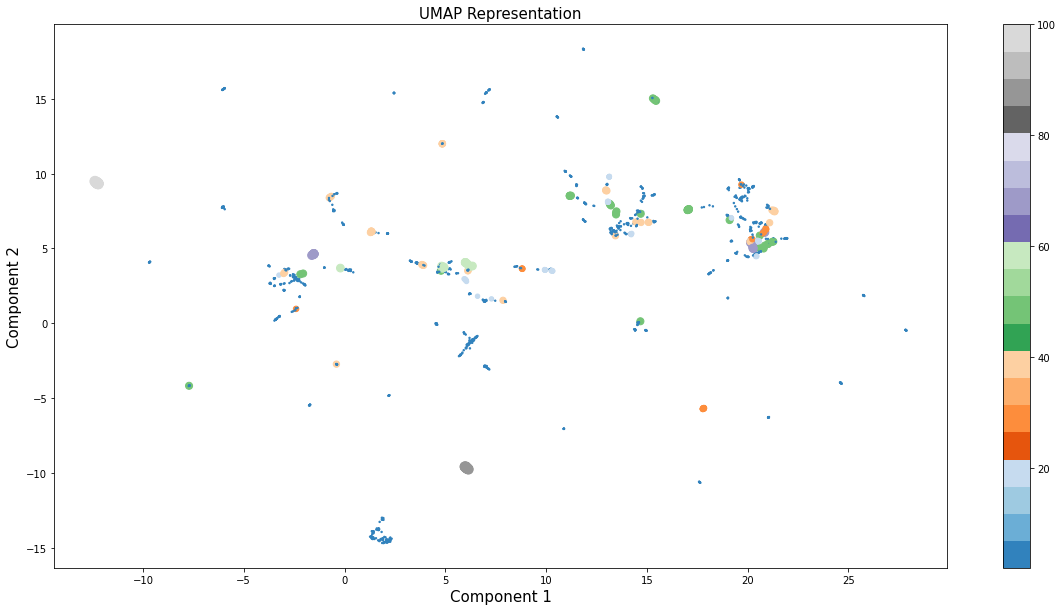

In [51]:
#scatter(u[:,0],u[:,1],s=2,c=col,cmap="hsv")
scatter(u[:,0],u[:,1],s=ncol,c=ncol,cmap="tab20c")
colorbar()
title("UMAP Representation",fontsize=15)
xlabel("Component 1",fontsize=15)
ylabel("Component 2",fontsize=15)
figsize(20,10)

#### dbGAP

In [66]:
from sklearn.cluster import DBSCAN
dbg=DBSCAN(eps=0.15,metric="precomputed",min_samples=5).fit(distances)

In [67]:
dbg.labels_

array([ 0,  1,  1,  2,  2,  2,  2, -1, -1, -1, -1,  2,  2,  2,  2,  2, -1,
       -1, -1,  3,  3,  3,  3,  3,  3,  3,  4,  4, -1, -1,  5,  5,  5,  5,
       -1,  5,  5,  5, -1, -1, -1, -1, -1,  1,  3,  2,  2,  2,  2,  2, -1,
       -1, -1, -1,  6,  6,  6,  6,  6, -1,  7,  7,  7,  7,  7,  7,  7,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  8,  8,  8,  8,  8,
        8,  8, -1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, -1,
       -1, -1, -1, -1, -1,  2,  1,  1,  1,  8,  8,  8,  8,  8,  8,  2,  2,
        2,  2,  1, -1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  9,  9,  9,  9,  9,  2,  2, -1, -1,  1,  1, 10, 10,
       10, 10, 10, 10, 10,  4,  7,  7,  7, -1, -1,  9, -1, -1,  4,  4,  4,
        4,  4, 11, 11, 11, 11, 11,  2, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12,  8,  8,  8,  8,  8,  8,  8,  8,
        8, -1, -1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
        2,  2,  2,  2,  2

In [68]:
dbscanCols=[]
for i in dbg.labels_:
    if i==-1:
        dbscanCols.append(0)
    elif i==0:
        dbscanCols.append(25*10)
    else:
        if (i+1)%2==0:
            dbscanCols.append((i+1)*10)
        else:
            dbscanCols.append((i+1)*-10)

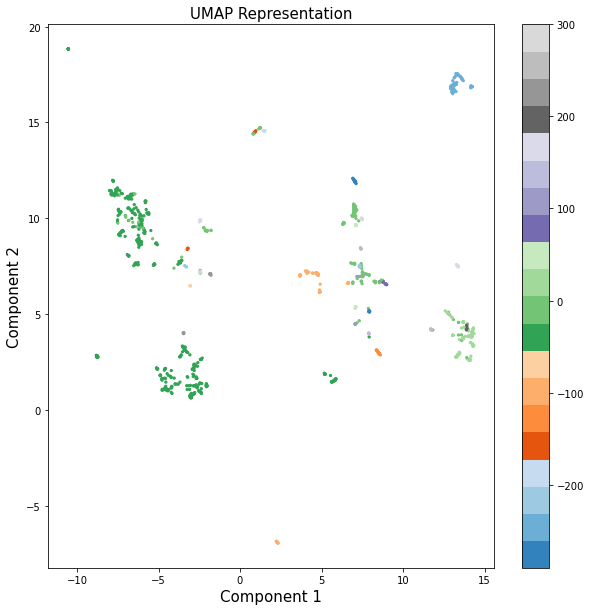

In [69]:
scatter(u[:,0],u[:,1],s=5,c=dbscanCols,cmap="tab20c")
colorbar()
title("UMAP Representation",fontsize=15)
xlabel("Component 1",fontsize=15)
ylabel("Component 2",fontsize=15)
figsize(10,10)

#### Mash Distance Analysis (All BioProjects)

In [29]:
group_distances=[]
diff_distances=[]

for i in range(1,distances.shape[0]):
    for j in range(0,i):
        if col[i]==col[j]:
            #if distances[i,j]==1.0:
                #print(i)
                #print(j)
                #print("===")
            group_distances.append(distances[i,j])
        else:
            #if distances[i,j]<0.1:
                #print(i)
                #print(j)
                #print("===")
            diff_distances.append(distances[i,j])

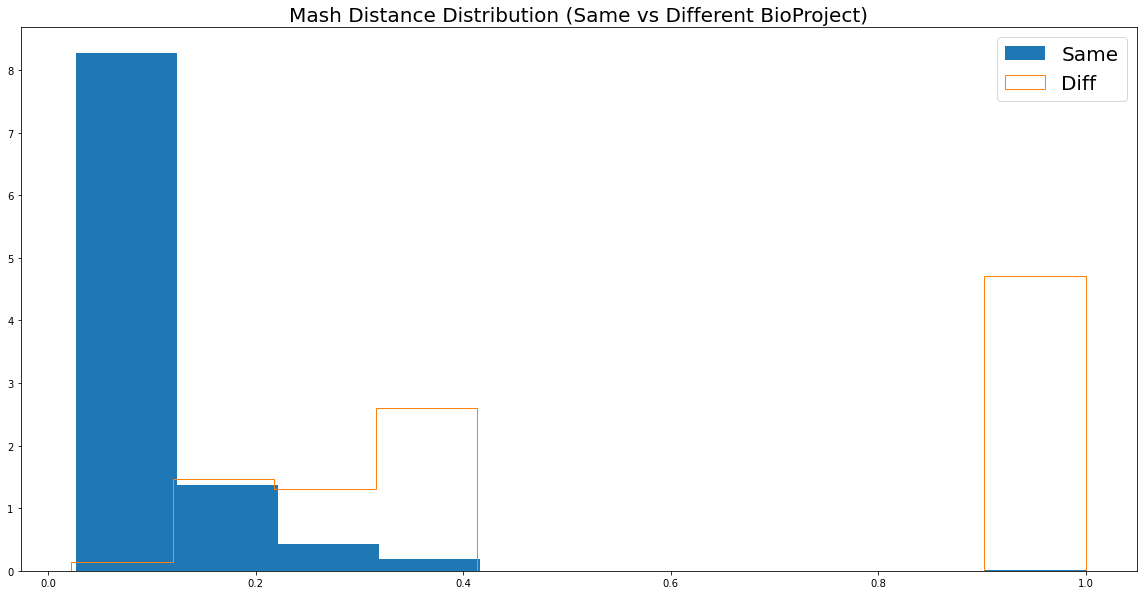

In [30]:
hist(group_distances,histtype='bar',label="Same", density=True)
hist(diff_distances,histtype='step',label="Diff", density=True)
title("Mash Distance Distribution (Same vs Different BioProject)", fontsize=20)
legend(prop={'size': 20})

In [31]:
from scipy.stats import ranksums,kstest

print(ranksums(group_distances,diff_distances))

print(kstest(group_distances,diff_distances))

RanksumsResult(statistic=-98.18862897166156, pvalue=0.0)
KstestResult(statistic=0.8368871504545193, pvalue=0.0)


#### Mash Distance Analysis (Keywords/MeSH Terms)

In [34]:
group_distances=[]
diff_distances=[]

for i in range(1,distances.shape[0]):
    for j in range(0,i):
        if ncol[i]==ncol[j]:
            #if distances[i,j]==1.0:
                #print(i)
                #print(j)
                #print("===")
            group_distances.append(distances[i,j])
        else:
            #if distances[i,j]<0.1:
                #print(i)
                #print(j)
                #print("===")
            diff_distances.append(distances[i,j])

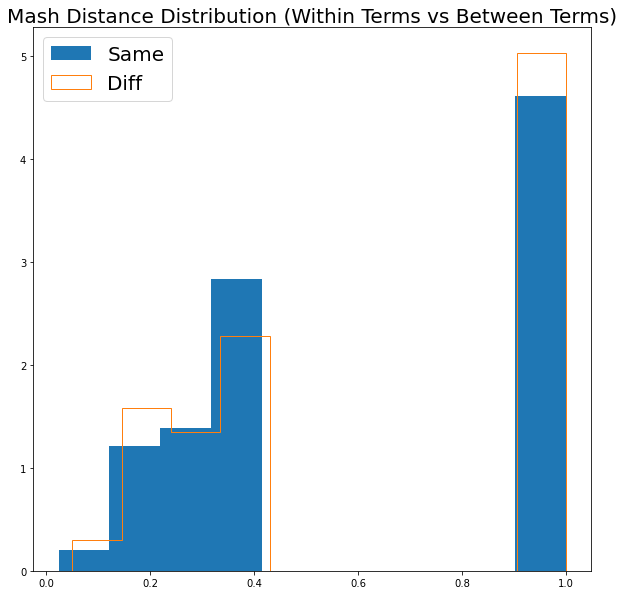

In [35]:
hist(group_distances,histtype='bar',label="Same", density=True)
hist(diff_distances,histtype='step',label="Diff", density=True)
title("Mash Distance Distribution (Within Terms vs Between Terms)", fontsize=20)
legend(prop={'size': 20})

In [36]:
from scipy.stats import ranksums,kstest

print(ranksums(group_distances,diff_distances))

print(kstest(group_distances,diff_distances))

RanksumsResult(statistic=-11.084708783413681, pvalue=1.4883393170118953e-28)
KstestResult(statistic=0.027448891609998527, pvalue=8.373346230555058e-71)


#### Test for Significant Differences in Clustering for Keywords

In [20]:
import statistics 
import random
def aleatorizationForTerms(dist,times,labels):
    differences=[]
    newlabels=labels
    for i in range(0,times):
        random.shuffle(newlabels)
        group_distances=[]
        diff_distances=[]

        for i in range(1,dist.shape[0]):
            for j in range(0,i):
                if newlabels[i]==newlabels[j]:
                    group_distances.append(dist[i,j])
                else:
                    diff_distances.append(dist[i,j])
        differences.append(statistics.median(diff_distances)-statistics.median(group_distances))
    differences.sort()
    return differences

In [ ]:
from scipy.stats import ranksums,kstest
significant=[]
abSignificant=[]
abundance=[]
for term in kwordtoProj.keys():
    abundance.append(len(kwordtoProj[term]))
    if len(kwordtoProj[term])<5:
        continue
    print(term)
    ncol,thisColMap=change_col(kwordtoProj,[term],0)
    group_distances=[]
    diff_distances=[]

    for i in range(1,distances.shape[0]):
        for j in range(0,i):
            if ncol[i]==ncol[j]:
                group_distances.append(distances[i,j])
            else:
                diff_distances.append(distances[i,j])
    a,b=ranksums(group_distances,diff_distances)
    c,d=kstest(group_distances,diff_distances)
    actual_diff=statistics.median(diff_distances)-statistics.median(group_distances)
    Randdiff=aleatorizationForTerms(distances,1000,ncol)
    SignPos=int((len(Randdiff)*0.01))
    if b<0.01/(2*len(kwordtoProj)) and d<0.01/(2*len(kwordtoProj)) and Randdiff[SignPos]>actual_diff:
        abSignificant.append(len(kwordtoProj[term]))
        significant.append(term)
        print(term+"\t"+str(len(kwordtoProj[term])))

microbiota
ophiocordyceps
cicadas
parasitic fungi
symbiotic fungi
16s rrna
microbiome
unclassified sequences
metagenome
organismal metagenomes
root metagenome
archaea
ecological metagenomes
soil metagenome
human gut metagenome
seawater metagenome
gut microbiome
gut microbiome	11
endophytes
ngs
diet
metagenomic sequencing
methane production
metagenomes
dna
rhizosphere
greenhouse
rhizosphere metagenome
mercury
chicken
gut microbiota
marine metagenome
16s
sediment metagenome
age
bacterial diversity
edna
rhodopseudomonas palustris
escherichia coli
static coculture
diversity
lake water metagenome
mechanism
mechanism	6
feces metagenome
ammonia
metatranscriptome
pinus banksiana
aeciospores
endocronartium harknessii
salt marsh
fungus metagenome
cenococcum
lateral roots
mycorrhiza
plant metagenome
bat
bat	28
metagenomic
sequencing
illumina
pathogen
hot springs metagenome
fungi
metabolism
bacterial communities
bacterial communities	10
viral
gut
marine sediment metagenome
coal metagenome
peat met

Text(0, 0.5, 'Frequency')

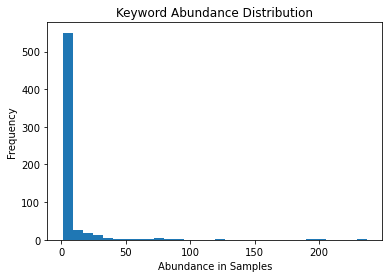

In [27]:
hist(abundance,histtype='bar', density=False,bins=30,)
title("Keyword Abundance Distribution")
xlabel("Abundance in Samples")
ylabel("Frequency")

In [52]:
abMeSH=[]
for i in MajMeSHtoProj.keys():
    abMeSH.append(len(MajMeSHtoProj[i]))

Text(0, 0.5, 'Frequency')

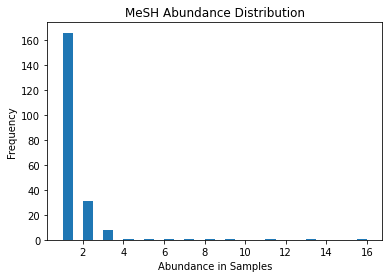

In [59]:
hist(abMeSH,histtype='bar', density=False,bins=30,)
title("MeSH Abundance Distribution")
xlabel("Abundance in Samples")
ylabel("Frequency")

#### Generate Metadata Table

In [37]:
keyIn=[]
for i in kwordtoProj.keys():
    if len(kwordtoProj[i])>4:
        keyIn.append(i)

table=open("DraftMetadata.tab","w")
header="id;Project"
for i in keyIn:
    header=header+"\t"+i
for j in MajMeSHtoProj:
    header=header+"\t"+j
table.write(header+"\n")

for i in range(len(ids)):
    line=str(ids[i])+"\t"+projects[col[i]]
    for z in keyIn:
        if projects[col[i]] in kwordtoProj[z]:
            line=line+"\t"+"Yes"
        else:
            line=line+"\t"+"No"
    for j in MajMeSHtoProj:
        if projects[col[i]] in MajMeSHtoProj[j]:
            line=line+"\t"+"Yes"
        else:
            line=line+"\t"+"No"
    table.write(line+"\n")
table.close()